In [1]:
#Studente: Luca Sugamosto, matricola 0324613

In [2]:
#pip install numpy
#pip install pandas
#pip install tensorflow
#pip install scikeras

In [3]:
"L'obiettivo del progetto è addestrare e valutare uno o più modelli di classificazione"
"In questa terza versione si utilizza la Convolutional Neural Network LeNet-5 per il calcolo dei parametri (w, b)"

# EXTENDED MNIST: versione estesa del dataset MNIST, conentente lettere alfabetiche invece delle cifre.
#                 Viene fornito un file CSV con circa 80000 immagini relative a lettere maiuscole o minuscole.
#                 Nella classificazione non occorre distinguere tra maiuscole e minuscole, quindi le classi da
#                 riconoscere sono 26.
#                 Ogni riga del file contiene l'etichetta della classe corrispondente all'immagine (un intero tra 1 e 26),
#                 seguita da 784 interi compresi tra 0 e 255 che codificano l'intensità di grigio di ogni pixel.

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

#La seguente istruzione permette di generare i grafici all'interno dello stesso file in uso
%matplotlib inline

#Inizializzazione delle dimensioni delle scritte nel grafico
mpl.rc('axes', labelsize = 14)                       
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

In [4]:
#Fase di inizializzazione sul Data Set:
df = pd.read_csv("emnist-letters.csv")               #Lettura del file contenente i campioni del Data Set
X = df.iloc[:, 1:]                                   #Creazione della tabella delle istanze di ingresso
Y = df.iloc[:, 0]                                    #Creazione del vettore delle etichette associate alle istanze d'ingresso

#Normalizzazione degli attributi dei vettori d'ingresso così da avere valori compresi tra [0,1]
X = X/255

#Con la seguente istruzione si prende la tabella delle istanze di ingresso e si crea un vettore di 88800 elementi,
#dove ogni elemento è una matrice di dimensione 28 x 28 che sta ad indicare una singola instanza di ingresso
X = X.to_numpy().reshape(-1, 28, 28, order = "F")
print("Dimensione della variabile X:", X.shape, "\n")

#Con la seguente istruzione si prende la colonna delle etichette selezionata in precedenza e si trasforma
#in un vettore di dimensione 88800 x 1; in aggiunta il "-1" permette di indicare le 26 classi a partire
#dall'indice 0 e non 1. Quindi Y ha valori al suo interno compresi  tra 0 e 25
Y = Y.to_numpy()-1
print("Dimensione della variabile Y:", Y.shape, "\n")

#Suddivisione delle istanze del Data Set in Training Set e Test Set (rispettivamente 80% e 20%)
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#Suddivisione delle istanze del Training Set appena creato in Training Set e Validation Set (rispettivamente 85% e 15%)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_full, Y_train_full, test_size = 0.15, random_state = 42)

print("Numero di campioni contenuti nel Training Set:", X_train.shape[0])
print("Numero di campioni contenuti nel Validation Set:", X_validation.shape[0])
print("Numero di campioni contenuti nel Test Set:", X_test.shape[0])

Dimensione della variabile X: (88800, 28, 28) 

Dimensione della variabile Y: (88800,) 

Numero di campioni contenuti nel Training Set: 60384
Numero di campioni contenuti nel Validation Set: 10656
Numero di campioni contenuti nel Test Set: 17760


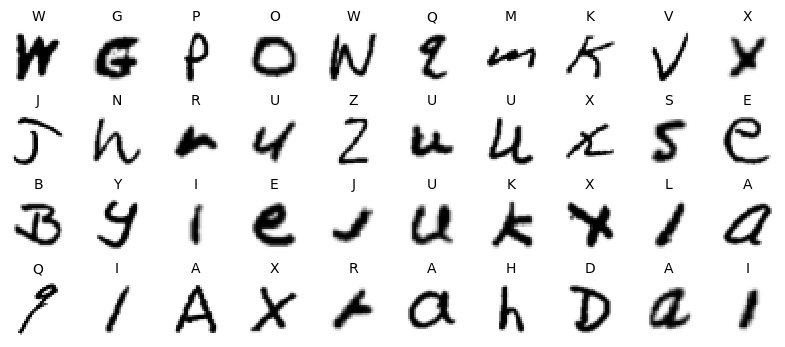

In [5]:
#Stampa a schermo di alcune istanze di ingresso (immagini di lettere scritte a mano)
#da passare successivamente in ingresso alla rete neurale
NN_input = X                                         #Si considera tutto il Data Set
NN_output = Y                                        #Si considera tutto il Data Set

#Sempre per un fatto legato alla stampa a schermo, si inizializza un vettore
#contenente tutte le 26 lettere dell'alfabeto per mostrare quale è la lettera reale
#associata all'immagine stampata
class_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L",
               "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
               "Y", "Z"]

n_rows = 4                                           #Numero di immagini da stampare per riga
n_cols = 10                                          #Numero di immagini da stampare per colonna
plt.figure(figsize = (n_cols * 1, n_rows * 1))       #Dimensione delle singole immagini da stampare
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(NN_input[index], cmap = "binary", interpolation = "nearest")
        plt.axis('off')
        plt.title(class_names[NN_output[index]], fontsize = 10)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)      #Spazio in altezza e larghezza tra le varie immagini
plt.show()

In [6]:
#Affinchè i vettori d'ingresso possano essere analizzati dalla CNN
#bisogna ridimensionare le istanze d'ingresso del Data Set in modo 
#da avere un singolo canale di uscita
X_train2 = X_train.reshape(-1, 28, 28, 1)            #il parametro "1" indica il fatto di avere un solo canale di uscita
X_validation2 = X_validation.reshape(-1, 28, 28, 1)  #il parametro "1" indica il fatto di avere un solo canale di uscita
X_test2 = X_test.reshape(-1, 28, 28, 1)              #il parametro "1" indica il fatto di avere un solo canale di uscita

print("Dimensioni dei campioni del Training Set:", X_train2.shape)
print("Dimensione dei campioni del Validation Set:", X_validation2.shape)
print("Dimensione dei campioni del Test Set:", X_test2.shape)

Dimensioni dei campioni del Training Set: (60384, 28, 28, 1)
Dimensione dei campioni del Validation Set: (10656, 28, 28, 1)
Dimensione dei campioni del Test Set: (17760, 28, 28, 1)


In [7]:
#Fase di implementazione della CNN LeNet:
    #Si compone di strati convoluzionali e strati di aggregazione alternati
    #per poi terminare con strati completamente connessi (strati densi)
    
    #I parametri associati ad ogni strato sono caratteristici della rete neurale LeNet.
    #La funzione di attivazione per gli strati nascosti è la "sigmoide"
lenet = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, activation = 'sigmoid', padding = 'same', input_shape = (28, 28, 1)),
        tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2),
        tf.keras.layers.Conv2D(filters = 16, kernel_size = 5,activation = 'sigmoid', padding = "valid"),
        tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation = 'sigmoid'),
        tf.keras.layers.Dense(84, activation = 'sigmoid'),
        tf.keras.layers.Dense(26, activation = "softmax")])

lenet.compile(
    loss = "sparse_categorical_crossentropy",                #Funzione di perdita per il calcolo dell'errore
    optimizer = keras.optimizers.Adam(),                     #Algoritmo di ottimizzazione dei parametri
    metrics = ["accuracy"]                                   #Funzione per valutare le prestazioni del modello
)

lenet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               

In [8]:
#Fase di addestramento della CNN:
history = lenet.fit(X_train2, 
                    Y_train, 
                    batch_size = 32,                                  #Numero di campioni contenuti in ogni mini-batch
                    epochs = 45,                                      #Numero di volte che tutti i campioni devono essere analizzati
                    validation_data = (X_validation2, Y_validation),  #Si passa il Validation Set per monitorare la perdita 
                                                                      #di convalida e le metriche alla fine di ogni epoca
                    
                    #Si introduce la tecnica di arresto anticipato; il parametro in ingresso indica
                    #il numero di epoche senza miglioramento dopo le quali l'algoritmo viene interrotto
                    callbacks = [keras.callbacks.EarlyStopping(patience = 15)])

#Salvataggio dei valori ottenuti durante l'addestramento tramite la
#variabile "history" per poter successivamente graficarne l'andamento

Epoch 1/45


1887/1887 [==============================] - 11s 5ms/step - loss: 1.8164 - accuracy: 0.4841 - val_loss: 0.9811 - val_accuracy: 0.7155
Epoch 2/45
1887/1887 [==============================] - 10s 5ms/step - loss: 0.7516 - accuracy: 0.7773 - val_loss: 0.6071 - val_accuracy: 0.8194
Epoch 3/45
1887/1887 [==============================] - 10s 6ms/step - loss: 0.5241 - accuracy: 0.8384 - val_loss: 0.4662 - val_accuracy: 0.8591
Epoch 4/45
1887/1887 [==============================] - 11s 6ms/step - loss: 0.4211 - accuracy: 0.8683 - val_loss: 0.4010 - val_accuracy: 0.8749
Epoch 5/45
1887/1887 [==============================] - 10s 5ms/step - loss: 0.3630 - accuracy: 0.8847 - val_loss: 0.3541 - val_accuracy: 0.8881
Epoch 6/45
1887/1887 [==============================] - 10s 5ms/step - loss: 0.3231 - accuracy: 0.8965 - val_loss: 0.3186 - val_accuracy: 0.8992
Epoch 7/45
1887/1887 [==============================] - 11s 6ms/step - loss: 0.2970 - accuracy: 0.9036 - val_loss: 0.3111 - val_

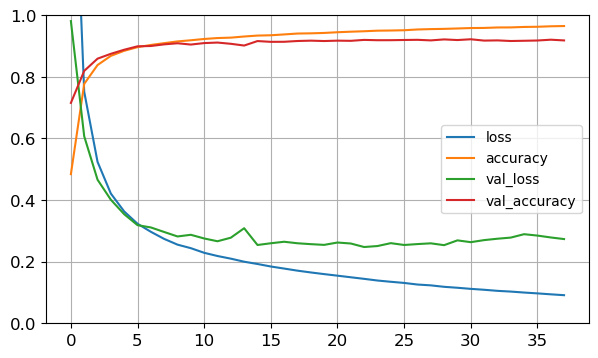

In [9]:
#Rappresentazione grafica dei risultati ottenuti in termini
#di perdita ed accuratezza durante la fase di addestramento
pd.DataFrame(history.history).plot(figsize = (7, 4))           #Dimensione del grafico 2D
plt.grid(True)                                                 #Presenza della griglia del grafico 2D
plt.gca().set_ylim(0, 1)                                       #Range dai valori assunti dagli assi
plt.show()

In [10]:
#Verifica della bontà dei parametri (w, b) ottenuti utilizzando come 
#algoritmo di ottimizzazione il Adam.
#Si utilizza in questo caso lo stesso modello con in ingresso il Test Set
print("-----Evaluate on Test Set-----\n")
print("Valori di perdita ed accuratezza sul Test Set (1):")
results = lenet.evaluate(X_test2, Y_test, batch_size = 32)     #Con questa funzione si utilizza la rete neurale già creata
                                                               #con i parametri addestrati, per calcolare accuratezza e
                                                               #perdita sul Test Set

-----Evaluate on Test Set-----

Valori di perdita ed accuratezza sul Test Set (1):
555/555 [==============================] - 2s 3ms/step - loss: 0.2748 - accuracy: 0.9226


Nella seguente porzione di codice si inizializza ed addestra una seconda CNN LeNet,
che a differenza della prima utilizza come funzione di attivazione la reLU:

In [11]:
#E' possibile considerare la stessa Convolutional Neural Network di prima, utilizzando
#però al posto della funzione di attivazione "sigmoide", la funzione di attivazione "reLU"
#studiando le eventuali differenze

#Fase di implementazione della CNN LeNet:
    #Si compone di strati convoluzionali e strati di aggregazione alternati,
    #per poi terminare in strati completamente connessi (strati densi)
    
    #I parametri associati ad ogni strato sono caratteristici della rete neurale LeNet.
    #La funzione di attivazione per gli strati nascosti è la "reLU"
lenet_2 = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (28, 28, 1)),
          tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2),
          tf.keras.layers.Conv2D(filters = 16, kernel_size = 5,activation = 'relu', padding = "valid"),
          tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(120, activation = 'relu'),
          tf.keras.layers.Dense(84, activation = 'relu'),
          tf.keras.layers.Dense(26, activation = "softmax")])

lenet_2.compile(
    loss = "sparse_categorical_crossentropy",                #Funzione di perdita per il calcolo dell'errore
    optimizer = keras.optimizers.Adam(),                     #Algoritmo di ottimizzazione dei parametri
    metrics = ["accuracy"]                                   #Funzione per valutare le prestazioni del modello
)

lenet_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [12]:
#Fase di addestramento della CNN:
history_2 = lenet_2.fit(X_train2, 
                    Y_train, 
                    batch_size = 32,                                  #Numero di campioni contenuti in ogni mini-batch
                    epochs = 45,                                      #Numero di volte che tutti i campioni devono essere analizzati
                    validation_data = (X_validation2, Y_validation),  #Si passa il Validation Set per monitorare la perdita 
                                                                      #di convalida e le metriche alla fine di ogni epoca
                    
                    #Si introduce la tecnica di arresto anticipato; il parametro in ingresso indica
                    #il numero di epoche senza miglioramento dopo le quali l'algoritmo viene interrotto
                    callbacks = [keras.callbacks.EarlyStopping(patience = 15)])

#Salvataggio dei valori ottenuti durante l'addestramento tramite la
#variabile "history" per poter successivamente graficarne l'andamento

Epoch 1/45
1887/1887 [==============================] - 11s 5ms/step - loss: 0.7107 - accuracy: 0.7804 - val_loss: 0.3960 - val_accuracy: 0.8727
Epoch 2/45
1887/1887 [==============================] - 10s 6ms/step - loss: 0.3331 - accuracy: 0.8896 - val_loss: 0.3321 - val_accuracy: 0.8875
Epoch 3/45
1887/1887 [==============================] - 10s 5ms/step - loss: 0.2742 - accuracy: 0.9068 - val_loss: 0.2884 - val_accuracy: 0.9024
Epoch 4/45
1887/1887 [==============================] - 10s 6ms/step - loss: 0.2381 - accuracy: 0.9173 - val_loss: 0.2696 - val_accuracy: 0.9078
Epoch 5/45
1887/1887 [==============================] - 10s 5ms/step - loss: 0.2140 - accuracy: 0.9260 - val_loss: 0.2651 - val_accuracy: 0.9147
Epoch 6/45
1887/1887 [==============================] - 10s 5ms/step - loss: 0.1925 - accuracy: 0.9319 - val_loss: 0.2492 - val_accuracy: 0.9145
Epoch 7/45
1887/1887 [==============================] - 10s 6ms/step - loss: 0.1777 - accuracy: 0.9362 - val_loss: 0.2400 - val_ac

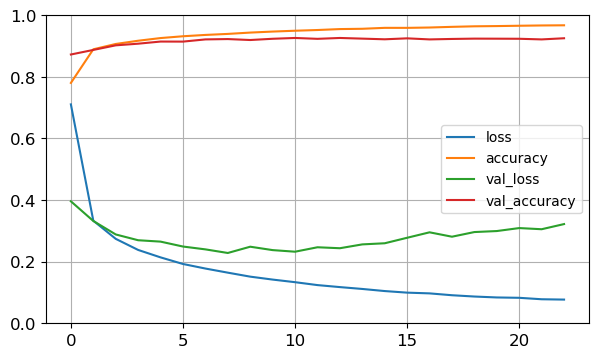

In [13]:
#Rappresentazione grafica dei risultati ottenuti in termini
#di perdita ed accuratezza durante la fase di addestramento
pd.DataFrame(history_2.history).plot(figsize = (7, 4))         #Dimensione del grafico 2D
plt.grid(True)                                                 #Presenza della griglia del grafico 2D
plt.gca().set_ylim(0, 1)                                       #Range dai valori assunti dagli assi
plt.show()

In [14]:
#Verifica della bontà dei parametri (w, b) ottenuti utilizzando come 
#algoritmo di ottimizzazione il Adam.
#Si utilizza in questo caso lo stesso modello con in ingresso il Test Set
print("-----Evaluate on Test Set-----\n")
print("Valori di perdita ed accuratezza sul Test Set (1):")
results = lenet.evaluate(X_test2, Y_test, batch_size = 32)     #Con questa funzione si utilizza la rete neurale già creata
                                                               #con i parametri addestrati, per calcolare accuratezza e
                                                               #perdita sul Test Set

-----Evaluate on Test Set-----

Valori di perdita ed accuratezza sul Test Set (1):
555/555 [==============================] - 2s 3ms/step - loss: 0.2748 - accuracy: 0.9226
